In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sc

%matplotlib inline

In [30]:
train = pd.read_csv('data/train_final.csv', delimiter='\t')
playlists = pd.read_csv('data/playlists_final.csv', delimiter='\t')
target_playlists = pd.read_csv('data/target_playlists.csv', delimiter='\t')
target_tracks = pd.read_csv('data/target_tracks.csv', delimiter = '\t')
tracks = pd.read_csv('data/tracks_final.csv', delimiter='\t')

In [29]:
playlists.apply(lambda x : len(x['title'].split(',')), axis=1).max()

30

In [17]:
pd.unique(train['playlist_id']).size

45649

In [18]:
pd.unique(train['track_id']).size

99999

In [19]:
99999*45649

4564854351

In [20]:
density = len(train) / (99999 * 45649)

In [21]:
density

0.00022794199332385227

In [31]:
len(tracks)

100000

In [32]:
len(target_tracks)

32195

In [35]:
s = set(target_tracks['track_id'])

In [37]:
s2 = set(tracks['track_id'])

In [45]:
pl = set(target_playlists['playlist_id'])

In [46]:
pl2 = set(playlists['playlist_id'])

In [47]:
all(x in pl2 for x in pl)

True

In [61]:
playlists['numtrack_token'] = pd.qcut(playlists['numtracks'], 6)

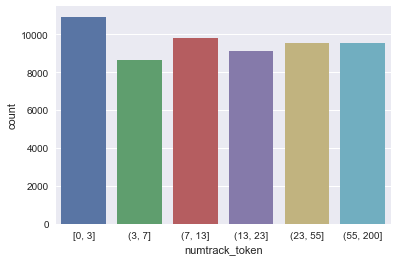

In [62]:
sns.countplot(x = 'numtrack_token', data=playlists)

In [63]:
empty_playlists = playlists[playlists['numtracks'] == 0]

In [64]:
len(empty_playlists)

1173

AttributeError: 'Series' object has no attribute 'val'

In [75]:
p2 = p.groupby('numtrack_token').count()

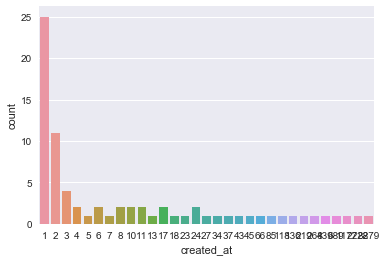

In [76]:
sns.countplot(x='created_at', data=p2)

In [86]:
playlists['created_at'].min()

1169657433

In [87]:
playlists['created_at'].max()

1423786569

In [88]:
1423786569 - 1169657433

254129136

In [89]:
254129136 / 1000 / (60 * 60)

70.59142666666666

70 ore

In [134]:
playlists[playlists['playlist_id'] == 34466]

,created_at,playlist_id,title,numtracks,duration,owner,numtrack_token


In [136]:
a = train[train['playlist_id'] == 11397138]

In [137]:
b = a['track_id'].values

In [138]:
sum([x['duration'] for _,x in tracks.iterrows() if x['track_id'] in b])

4577999

In [158]:
def check_playlist(playlist_id):
    duration = int(playlists[playlists['playlist_id'] == playlist_id]['duration'])
    pl_tracks = train[train['playlist_id'] == playlist_id]
    track_ids = pl_tracks['track_id'].values
    
    sum_duration = sum([x['duration'] for _,x in tracks.iterrows() if x['track_id'] in track_ids])
    return sum_duration/1000 <= duration

In [161]:
all(check_playlist(t['playlist_id']) for _,t in playlists.sample(10).iterrows())

True

In [135]:
playlists

,created_at,playlist_id,title,numtracks,duration,owner,numtrack_token
0,1216545588,644838,[12727],27,6522,41504,"(23, 55]"
1,1249326867,7577564,[],9,2650,41504,"(7, 13]"
2,1257766688,3120683,[183],16,3645,44542,"(13, 23]"
3,1248079275,4278112,"[12389, 18698, 18925, 11695, 7117]",15,4151,44542,"(13, 23]"
4,1175201268,8656823,"[12809, 2095, 13257, 12671, 20426, 14448, 18698]",84,18414,44542,"(55, 200]"
5,1224952363,10961458,"[7194, 3225, 9438, 13502, 11695]",32,6441,44542,"(23, 55]"
6,1171573001,5527068,[19505],44,13776,40796,"(23, 55]"
7,1220175946,2940714,[12323],69,18214,40796,"(55, 200]"
8,1181710641,11397138,[],27,8466,44467,"(23, 55]"
9,1181710641,3128020,"[12111, 4776, 14448]",89,30451,44467,"(55, 200]"


In [147]:
duration = playlists[playlists['playlist_id'] == 4146222]

In [148]:
duration

,created_at,playlist_id,title,numtracks,duration,owner,numtrack_token
57560,1323724772,4146222,[19676],10,2242,4950,"(7, 13]"


2242